In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torch.utils.data.dataset import Dataset

from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

import pandas as pd
import numpy as np

from PIL import Image as I
from IPython.display import Image
from IPython.core.display import Image, display

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 32

In [4]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path, transform):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        
        self.transform = transform

        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)

        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        single_image_name = "data-nodules2d/imgs/" + single_image_name + ".png"
        
        # Open image
        img_as_img = I.open(single_image_name)

        # Transform image to tensor
        img_as_tensor = self.transform(img_as_img)
        img_as_tensor = F.pad(img_as_tensor, (6,6,6,6), "constant", 0)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len


In [5]:
dataset = CustomDatasetFromImages(csv_path="./2dlabels.csv", transform = transforms.Compose([transforms.ToTensor()]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

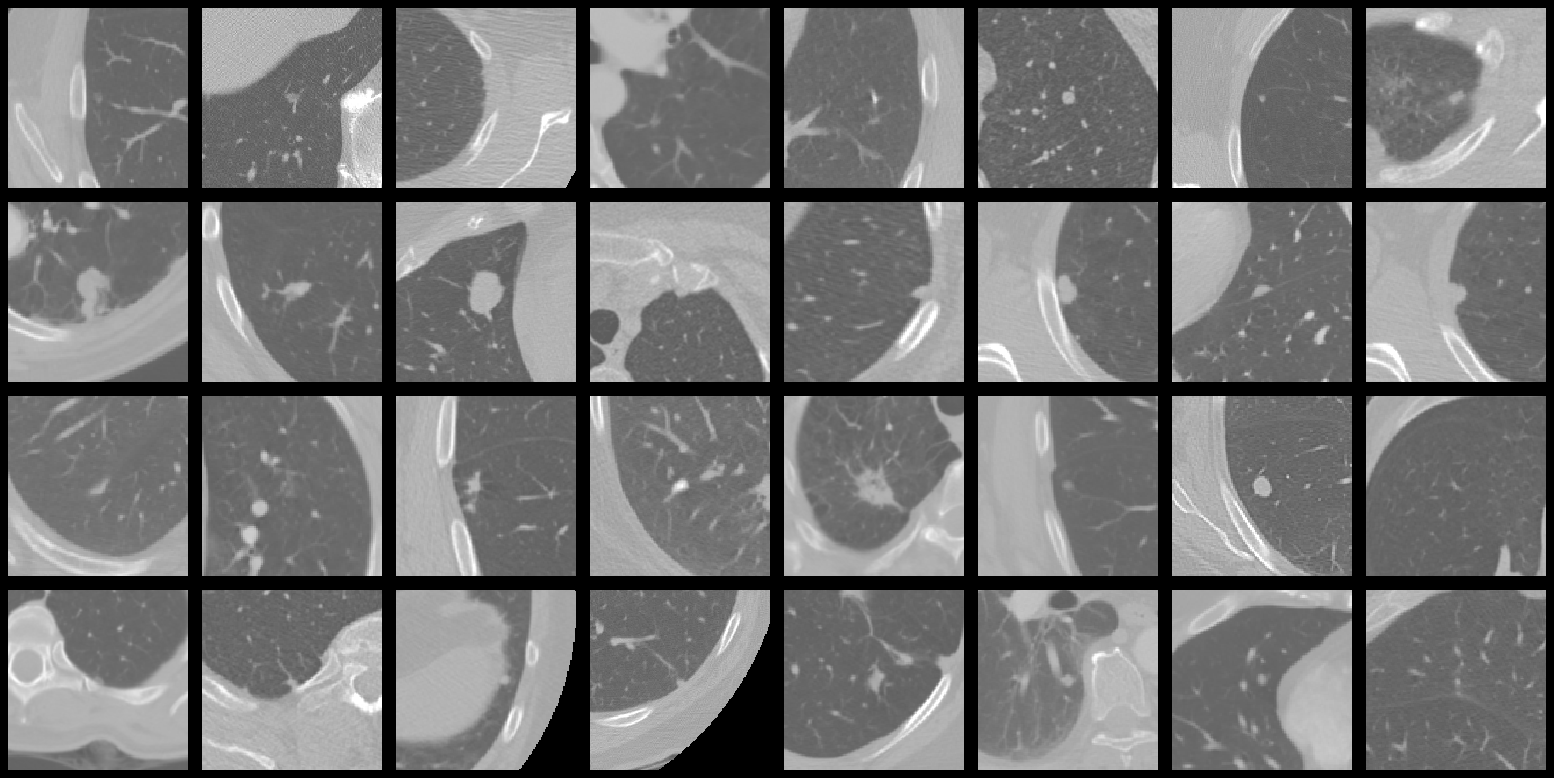

In [6]:
fixed_x, label = next(iter(dataloader))
fixed_x = fixed_x.to(device)
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [7]:
fixed_x.shape

torch.Size([32, 1, 192, 192])

In [8]:
class Net(nn.Module):
    def __init__(self, m, n=192):
        super(Net, self).__init__()
        self.n = n
        self.m = m
        self.d = n//m
        self.dd = self.d**2
        
        self.conv1 = nn.Conv2d(1, 16, 3, 1, padding = 1)
        self.pool1 = nn.MaxPool2d(2,2)
        
        self.conv = nn.ModuleList([
            nn.Conv2d(16, 32, 3, 1, padding = 1),
#             nn.Conv2d(32, 32, 3, 1, padding = 1),
            nn.Conv2d(32, 64, 3, 2, padding = 1),
#             nn.Conv2d(64, 64, 3, 1, padding = 1),
            nn.Conv2d(64, 128, 3, 2, padding = 1),
#             nn.Conv2d(128, 128, 3, 1, padding = 1),
            nn.Conv2d(128, 256, 3, 2, padding = 1),
#             nn.Conv2d(256, 256, 3, 1, padding = 1),
            nn.Conv2d(256, 512, 3, 2, padding = 1),
#             nn.Conv2d(512, 512, 3, 1, padding = 1)
        ])
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 512)
        self.regression = nn.Linear(128, 128)

        self.convrev = nn.ModuleList([
            nn.Conv2d(512,256,3,1,padding = 1),
            nn.Conv2d(256,128,3,1,padding = 1),     
            nn.Conv2d(128,64,3,1,padding = 1),
            nn.Conv2d(64,32,3,1,padding = 1), 
            nn.Conv2d(32,1,3,1,padding = 1),
        ])
        
    
    def tiling(self, x):
        m = self.m
        d = self.d
        return x.unfold(2, m, m).unfold(3, m, m).reshape(-1, 1, m, m)
    
    
    def untiling(self, x):
        m = self.m
        d = self.d
        n = self.n
        
        x = x.view(-1, self.dd, m, m)
        x = x.view(-1, self.dd, m*m).permute(0, 2, 1)
        return F.fold(x, (n, n), (m, m), stride=(m, m))
    
    
    def upsample(self, x):
        m = self.m
        d = self.d
        
        x = self.fc2(x)
        x = x.reshape(-1, 512, 1, 1)
    
        for idx, conv in enumerate(self.convrev):
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = conv(x)
            if idx != len(self.convrev)-1:
                x = F.relu(x)
        
        x = torch.sigmoid(x)
        return x

    
    def downsample(self, x):
        d = self.d
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        for conv in self.conv:
            x = conv(x)
            x = F.relu(x)
        x = x.reshape(-1, 512)
        x = self.fc1(x)
        return x

    
    # Auto-encoder
    def reconstruction(self, x):
        x = self.tiling(x)
        v = x = self.downsample(x)
        x = self.upsample(x)
        x = self.untiling(x)
        return v, x


    def bert(self, v):
        dynamic_bs = v.shape[0]//self.dd
        # mask of all ones, except 0 at diagonals
        mask = (1- torch.eye(36)).to(device)
        mask = mask.repeat(dynamic_bs, 1, 1)
        
        v = v.reshape(dynamic_bs, self.dd, 128)
        
        # TODO: mean all vectors except me, using matrix multiplication
        vnot = torch.bmm(mask, v)/(self.dd-1)
        vnot = vnot.reshape(-1, 128)
        vprime = self.regression(vnot)        
        
        # using the same upsample between both reconstruction
        # enforces that the vectors are closer using both reconstruction and bert
        x = self.upsample(vprime)
        return self.untiling(x)    

    
    def forward(self, x):
        vectors, reconstructed = self.reconstruction(x)
        prime = self.bert(vectors)
        return reconstructed, prime

In [9]:
model = Net(m=32)
model.to(device)
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [10]:
a, b = model(fixed_x)

In [ ]:
def train(train_loader):
    epochs = 5
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            reconstructed, prime = model(data)
            
            loss1 = loss(data, reconstructed)
            # loss2 = loss(data, prime)
            loss2 = 0.0
            
            losses = loss1 + loss2
            losses.backward()
            
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss1.item(), loss1.item()))

train(dataloader)

Train Epoch: 0 [0/39274 (0%)]	Loss: 0.003429 0.003429
Train Epoch: 0 [3200/39274 (8%)]	Loss: 0.002733 0.002733
Train Epoch: 0 [6400/39274 (16%)]	Loss: 0.002747 0.002747
Train Epoch: 0 [9600/39274 (24%)]	Loss: 0.002315 0.002315
Train Epoch: 0 [12800/39274 (33%)]	Loss: 0.002166 0.002166
Train Epoch: 0 [16000/39274 (41%)]	Loss: 0.001636 0.001636
Train Epoch: 0 [19200/39274 (49%)]	Loss: 0.001665 0.001665
Train Epoch: 0 [22400/39274 (57%)]	Loss: 0.001532 0.001532


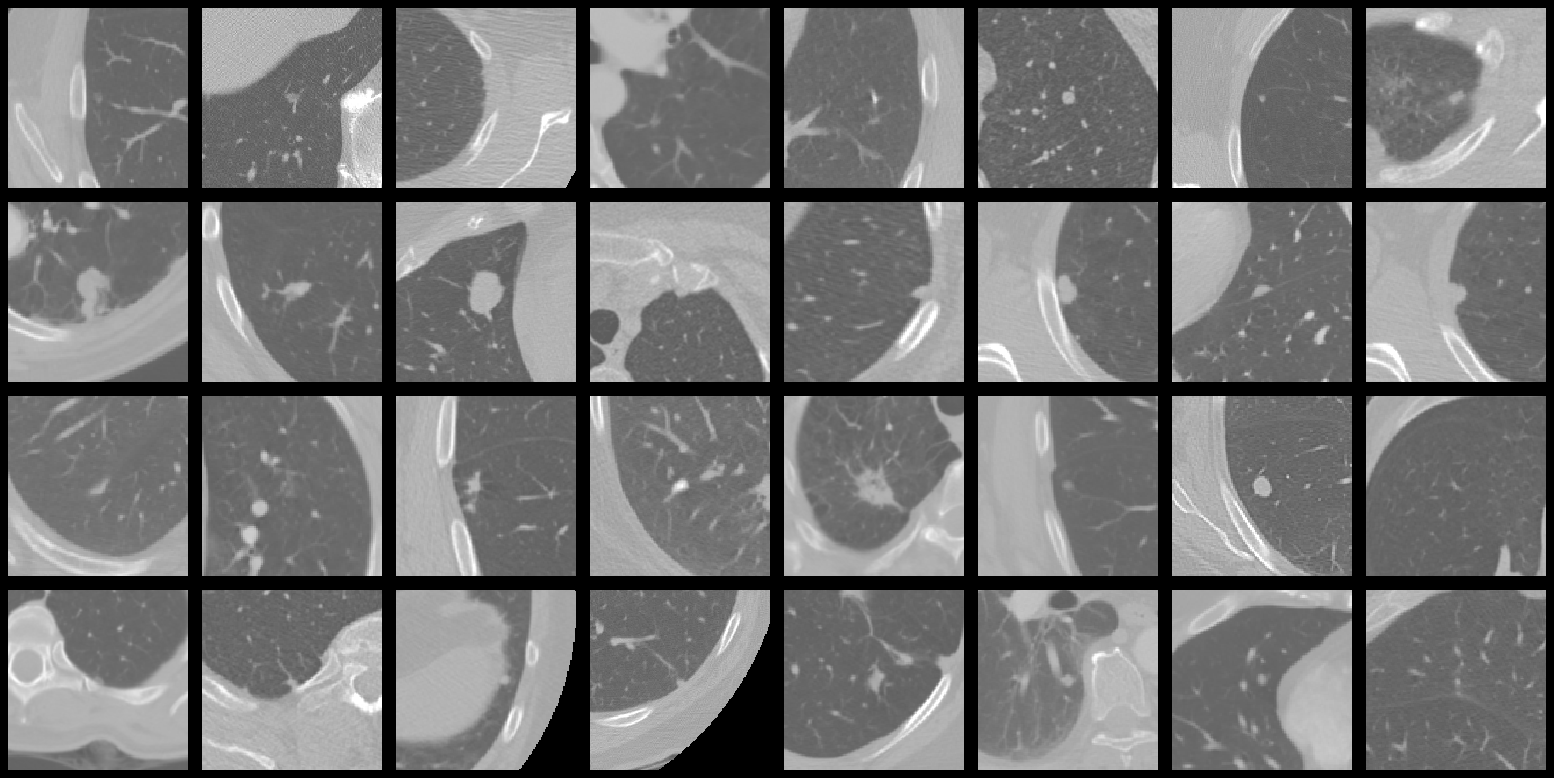

In [18]:
save_image(fixed_x, 'real_image.png')
Image('real_image.png')

In [19]:
re, pr = model(fixed_x)
re.shape

torch.Size([32, 1, 192, 192])

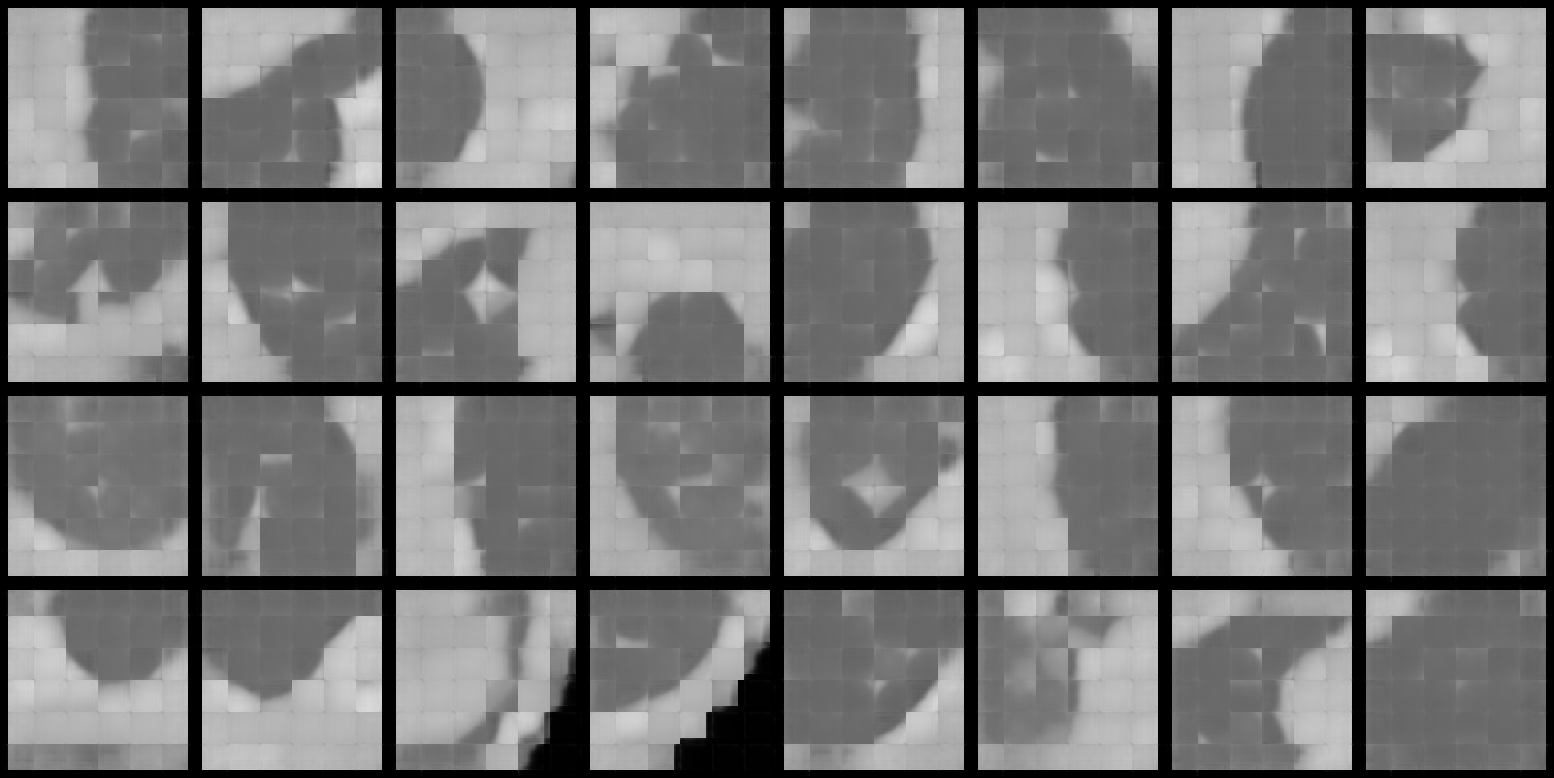

In [20]:
save_image(re, 'real_image.png')
Image('real_image.png')

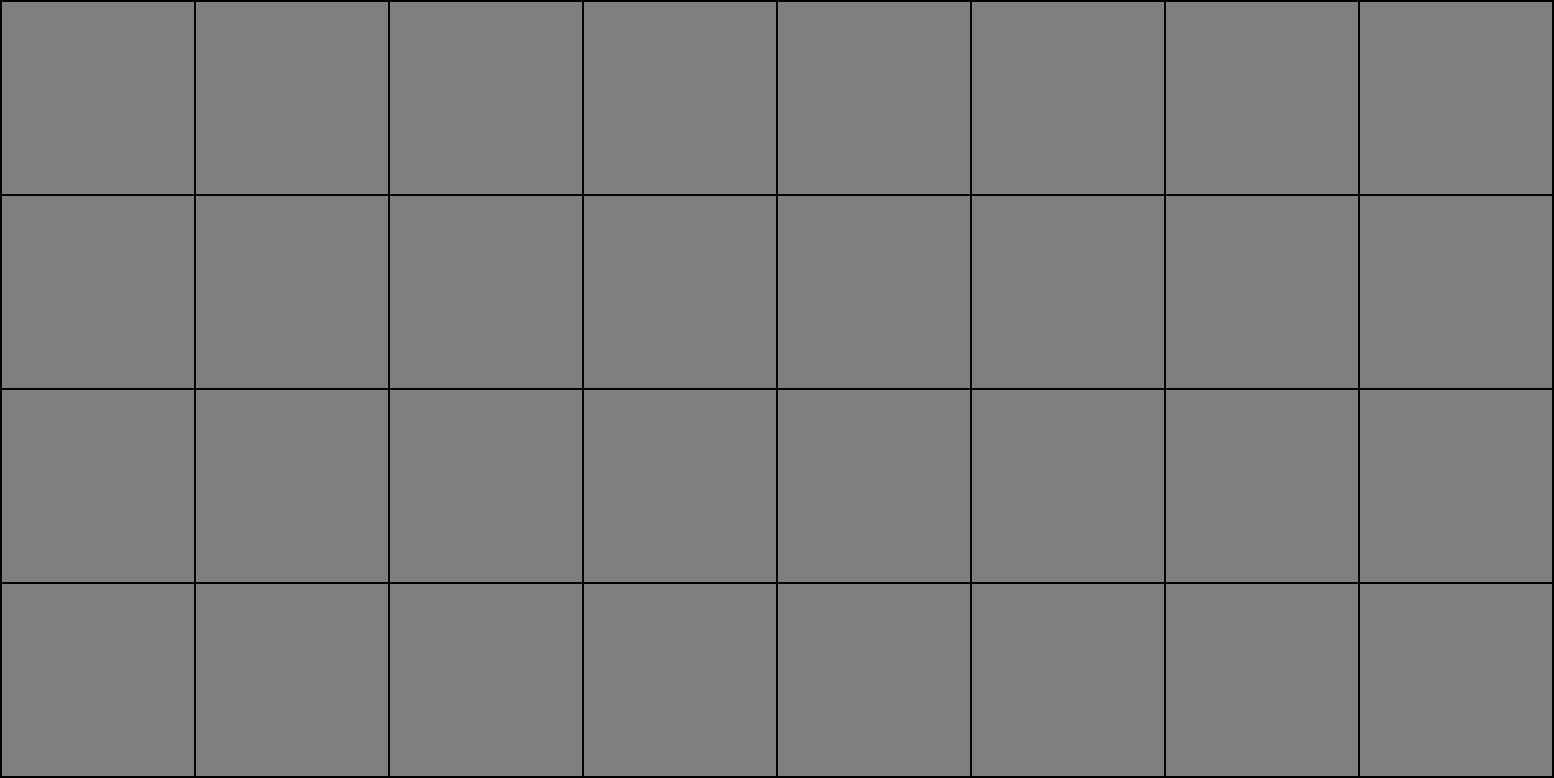

In [16]:
save_image(pr, 'real_image.png')
Image('real_image.png')

### Compute ROI

In [148]:
torch.matmul(model.Vprime, model.Vreconst.T).long()

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
class Evaluate(nn.Module):
    def __init__(self):
        super(Evaluate, self).__init__()
        self.fc1 = nn.Linear(128, 2)
    
    def forward(self,vector):
        x = self.fc1(vector)
        return x